# Education Data Analysis - Birth month vs Grades

Cleaned pipeline with proper decimal conversion for grade columns.

Generalized for all main primary and secondary "shared" subjects.

## 0. Importing, reading, cleaning

Execute this cells one by one or your kernell might die

In [1]:
import psutil
print(psutil.virtual_memory())

svmem(total=34359738368, available=11371663360, percent=66.9, used=15883558912, free=97214464, active=11279884288, inactive=11247239168, wired=4603674624)


In [4]:
import csv
import os
import gc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress  # for linear regression


In [3]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [5]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [6]:
# Keep only students present in both datasets
students_P = set(df_P['CODI_ALUMNE'].unique())
students_S = set(df_S['CODI_ALUMNE'].unique())

# Find matching students
matching_students = students_P.intersection(students_S)

print(f"Students in Primary: {len(students_P)}")
print(f"Students in Secondary: {len(students_S)}")
print(f"Matching students: {len(matching_students)}")

# Filter both dataframes
df_P = df_P[df_P['CODI_ALUMNE'].isin(matching_students)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching_students)].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

# Clear memory
gc.collect()


Students in Primary: 513377
Students in Secondary: 532090
Matching students: 251748


0

In [ ]:
def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    Optimized for large datasets with memory management.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    print(f"Found {len(grade_cols)} columns to convert...")
    
    for i, col in enumerate(grade_cols):
        try:
            # Replace comma with dot for decimal conversion
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            # Convert to numeric (invalid parsing becomes NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            if (i + 1) % 5 == 0:  # Progress check every 5 columns
                print(f"  Converted {i + 1}/{len(grade_cols)} columns...")
                gc.collect()
        
        except Exception as e:
            print(f"  Warning: Could not convert column {col}: {e}")
            continue
    
    return grade_cols

# Apply conversion separately to Primary and Secondary
print("Converting Primary grades...")
converted_P = convert_grades_to_numeric(df_P, prefix='P')
gc.collect()

print("Converting Secondary grades...")
converted_S = convert_grades_to_numeric(df_S, prefix='P')
gc.collect()

print(f"\nConverted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")


Converting Primary grades...
Found 24 columns to convert...
  Converted 5/24 columns...
  Converted 10/24 columns...
  Converted 15/24 columns...
  Converted 20/24 columns...
Converting Secondary grades...
Found 28 columns to convert...
  Converted 5/28 columns...
  Converted 10/28 columns...
  Converted 15/28 columns...
  Converted 20/28 columns...
  Converted 25/28 columns...

Converted 24 columns in Primary
Converted 28 columns in Secondary


In [ ]:
# Import plot style
plt.style.use("birthmonth.mplstyle")

In [ ]:
# ========== PRIMARY-SECONDARY COLOR PALETTE ==========
palette = {
    'primary': {
        # mid between primary male blue and primary female teal
        'points': '#2B7180',                 # real means + regression line
        'thermalized_band': '#92CFD0',       # light aqua band
        'thermalized_mean_line': '#008C8C',  # teal-blue null mean line
    },
    'secondary': {
        # mid between secondary male violet and secondary female orange
        'points': '#8A3C6A',                 # plum / magenta-brown
        'thermalized_band': '#F1B7D0',       # light rose band
        'thermalized_mean_line': '#B1447E',  # strong magenta-plum line
    }
}


In [54]:
# Create plot directories:
# Base directory: one level above current
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Root folder for these figures
birth_root = os.path.join(base_dir, "BirthMonth-Plots")

# Main subfolders
birth_dir_nogender = os.path.join(birth_root, "No-gender")
birth_dir_gender = os.path.join(birth_root, "Gender")

# New subfolders inside No-gender
birth_dir_nogender_primary = os.path.join(birth_dir_nogender, "Primary")
birth_dir_nogender_secondary = os.path.join(birth_dir_nogender, "Secondary")

# Create all folders if they do not exist
os.makedirs(birth_dir_nogender_primary, exist_ok=True)
os.makedirs(birth_dir_nogender_secondary, exist_ok=True)
os.makedirs(birth_dir_gender, exist_ok=True)

## 1. Initial plots

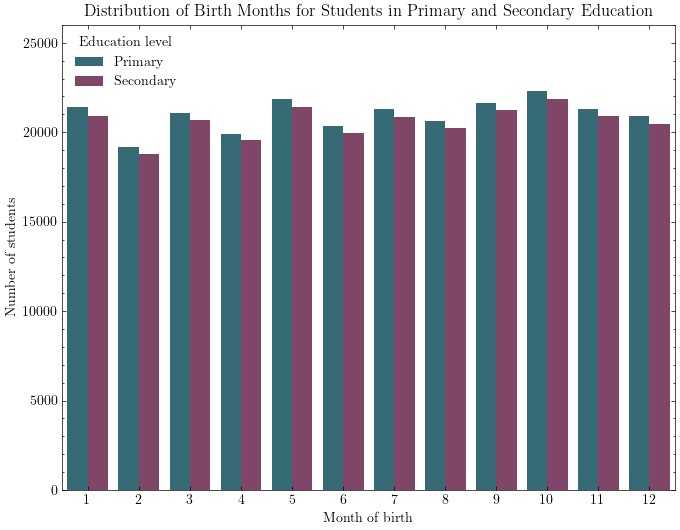

In [50]:
plt.style.use("birthmonth.mplstyle")

# ===============================
# Plot 1: Distribution of Birth Months
# ===============================
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting only
df_birth_months = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(
    df_birth_months['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# Use point colors from palette
hue_order = ['Primary', 'Secondary']
birth_palette = {
    'Primary':   palette['primary']['points'],
    'Secondary': palette['secondary']['points'],
}  # maps hue values to custom hex colors

fig, ax = plt.subplots()

sns.countplot(
    data=df_birth_months,
    x='MES_NAIXEMENT',
    hue='snapshot',
    hue_order=hue_order,
    palette=birth_palette,   # apply your custom colors
    ax=ax
)

# Set yrange from 0 to 25000
ax.set_ylim(0, 26000)

ax.set_title('Distribution of Birth Months for Students in Primary and Secondary Education')
ax.set_xlabel('Month of birth')
ax.set_ylabel('Number of students')
ax.legend(title='Education level', loc='upper left')
ax.tick_params(axis='x', which='minor', length=0)

filename = "1.birth_month_distribution_primary_secondary.png"
fig.savefig(os.path.join(birth_dir_nogender, filename), dpi=900, bbox_inches='tight')
fig.tight_layout()
plt.show()


In [14]:
plt.style.use("birthmonth.mplstyle")

# ===============================
# A starting visualization: CATALAN IN PRIMARY DISTRIBUTIONS
# ===============================
df_cat_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PCAT']].drop_duplicates('CODI_ALUMNE')
df_cat_P['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_P['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)
df_cat_P['snapshot'] = 'Primary'

df_cat_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PCAT']].drop_duplicates('CODI_ALUMNE')
df_cat_S['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_S['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)
df_cat_S['snapshot'] = 'Secondary'

df_cat_grades = pd.concat([df_cat_P, df_cat_S], ignore_index=True)

df_cat_grades['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_grades['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

hue_order = ['Primary', 'Secondary']
cat_palette = {
    'Primary':   palette['primary']['points'],
    'Secondary': palette['secondary']['points'],
}

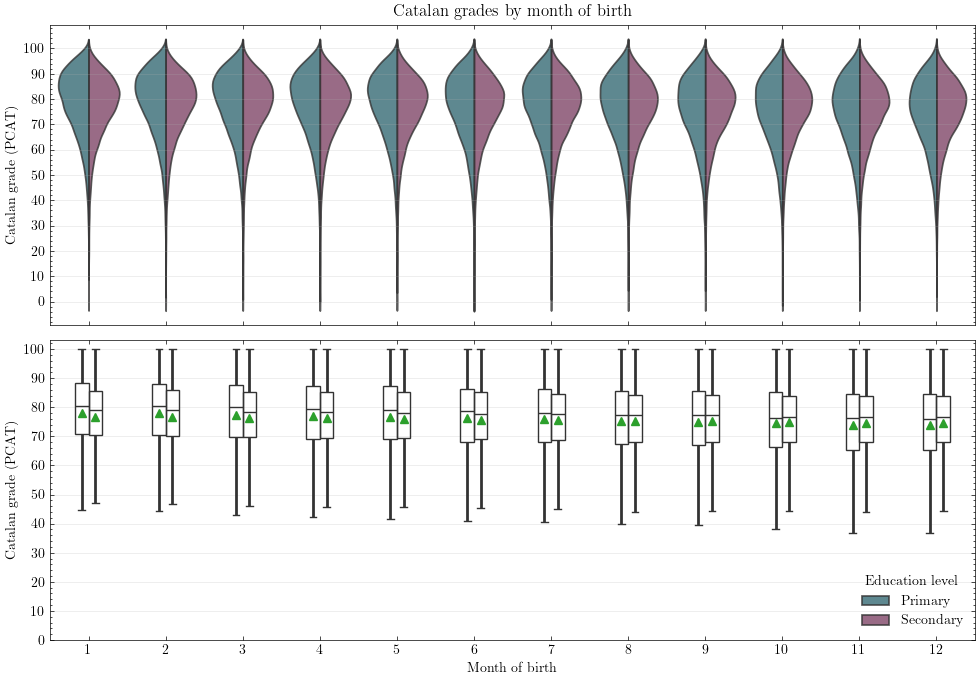

In [16]:
# ===============================
# Multiplot: violins (top) + boxes (bottom)
# ===============================
fig, (ax_violin, ax_box) = plt.subplots(
    2, 1,
    figsize=(10, 7),
    sharex=True
)

# --- Top: violin distributions ---
sns.violinplot(
    data=df_cat_grades,
    x='MES_NAIXEMENT',
    y='PCAT',
    hue='snapshot',
    hue_order=hue_order,
    palette=cat_palette,
    alpha=0.8,
    split=True,
    inner=None,
    ax=ax_violin
)

handles, labels = ax_violin.get_legend_handles_labels()

ax_violin.set_ylabel('Catalan grade (PCAT)')
ax_violin.set_title('Catalan grades by month of birth')


# --- Bottom: boxplots only ---
sns.boxplot(
    data=df_cat_grades,
    x='MES_NAIXEMENT',
    y='PCAT',
    hue='snapshot',
    hue_order=hue_order,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 3},
    showfliers=False,
    whiskerprops={'linewidth': 2},
    width=0.35,
    palette=cat_palette,
    ax=ax_box,
    showmeans=True, meanprops={'label': 'mean'}
)

ax_box.legend_.remove()

ax_box.set_ylabel('Catalan grade (PCAT)')
ax_box.set_xlabel('Month of birth')

ax_violin.set_yticks(range(0, 101, 10))
ax_box.set_yticks(range(0, 101, 10))

for ax in (ax_violin, ax_box):
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', which='minor', length=0)

plt.tight_layout()

# Get handles/labels from the top axis (violin)
handles, labels = ax_violin.get_legend_handles_labels()

# Remove legend from top axis
ax_violin.legend_.remove()

# Add legend to bottom axis, bottom-right
ax_box.legend(
    handles[:2], labels[:2],
    title='Education level',
    loc='lower right'
)

os.makedirs(birth_dir_nogender, exist_ok=True)
filename = "2.violin_box_multiplot_catalan_primary_secondary_.png"
fig.savefig(os.path.join(birth_dir_nogender, filename), dpi=600, bbox_inches='tight')

plt.show()

## 2. Generalized analysis of the means

Compute the error bars to the values. Also, when you do the thermalization, do a sigma, differenciate between the area of the biggest % of the lines and the one ouside. You will do that later by doing the fill in between with two grades of opacity. So that way, Im not only taking the maximum and the minimum y values, but seeing in this noise distribution what is relevant and what not.

In [17]:
# MAIN SUBJECTS:
subjects = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN', 'PMED']

subjects_P = [s for s in subjects if s in df_P.columns]
subjects_S = [s for s in subjects if s in df_S.columns]

print("Primary subjects:", subjects_P)
print("Secondary subjects:", subjects_S)


Primary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
Secondary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']


### Calculations

#### Implement a randomization of primary and secondary data. Add statistics

In [18]:
# --------------------------------------------------------
# 1. Thermalize one subject, with errors for the means
# --------------------------------------------------------
def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)

    Returns
    -------
    summary : DataFrame with month-level stats (months 1..12):
        month,
        real_mean       : empirical mean grade
        real_std        : sample standard deviation of grades in that month
        real_n          : number of students in that month
        real_sem        : standard error of the mean = real_std / sqrt(real_n)
        null_mean       : mean of null distribution (randomized months)
        null_std        : std of null distribution
        null_median     : median of null distribution
        q1, q3, iqr     : quartiles and IQR of null distribution
        z_score         : (real_mean - null_mean) / null_std
        z_iqr           : (real_mean - null_median) / iqr
        band_min, band_max : min / max of null means
        band_p16, band_p84 : ~68 % central band of null
        band_p2_5, band_p97_5 : ~95 % central band of null

    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (columns = months 1..12)
    """

    # Clean and keep only needed columns
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df[grade_col] = pd.to_numeric(df[grade_col], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # --- Real statistics per month (full 1..12 grid) ---
    grp = (
        df.groupby('MES_NAIXEMENT')[grade_col]
        .agg(['mean', 'std', 'count'])
        .reindex(months)
    )

    real_mean = grp['mean'].values
    real_std  = grp['std'].values
    real_n    = grp['count'].values

    real_sem = np.where(real_n > 0, real_std / np.sqrt(real_n), np.nan)

    # --- Simulations: null distribution via month randomization ---
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # --- Null distribution summaries over simulations ---
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Bands for visualization
    band_min   = np.nanmin(sim, axis=0)
    band_max   = np.nanmax(sim, axis=0)
    band_p16   = np.nanpercentile(sim, 16,  axis=0)
    band_p84   = np.nanpercentile(sim, 84,  axis=0)
    band_p2_5  = np.nanpercentile(sim, 2.5, axis=0)
    band_p97_5 = np.nanpercentile(sim, 97.5, axis=0)

    summary = pd.DataFrame({
        'month':       months,
        'real_mean':   real_mean,
        'real_std':    real_std,
        'real_n':      real_n,
        'real_sem':    real_sem,
        'null_mean':   null_mean,
        'null_std':    null_std,
        'null_median': null_med,
        'q1':          q1,
        'q3':          q3,
        'iqr':         iqr,
        'z_score':     z,
        'z_iqr':       z_iqr,
        'band_min':    band_min,
        'band_max':    band_max,
        'band_p16':    band_p16,
        'band_p84':    band_p84,
        'band_p2_5':   band_p2_5,
        'band_p97_5':  band_p97_5,
    })

    return summary, sim


In [19]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# 1. Run analysis for all subjects
# --------------------------------------------------------
primary_summaries = {}   # dict: subj -> summary DataFrame
primary_sims = {}        # dict: subj -> sim array
all_summaries = []

for subj in subjects_P:
    # Base dataframe for this subject in Primary
    df_subj_P = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    # Thermalization by month (uses new function with real_mean, real_sem, bands, etc.)
    summary_P, sim_P = thermalize_subject_by_month(
        df_level=df_subj_P,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=42
    )

    summary_P['subject'] = subj
    summary_P['snapshot'] = 'Primary'

    primary_summaries[subj] = summary_P
    primary_sims[subj] = sim_P
    all_summaries.append(summary_P)

# Long-format dataset with all Primary stats (all subjects, all months)
# Includes real_mean, real_std, real_n, real_sem, bands, z_score, z_iqr, etc.
df_stats_primary_all = pd.concat(all_summaries, ignore_index=True)


In [20]:
#--------------------------
# SECONDARY MAIN SUBJECTS
#--------------------------
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
n_iter = 2000

# --------------------------------------------------------
# 2. Run analysis for all subjects
# --------------------------------------------------------
secondary_summaries = {}
secondary_sims = {}

for subj in subjects_S:
    df_subj_S = (
        df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    summary_S, sim_S = thermalize_subject_by_month(
        df_level=df_subj_S,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=84  # different seed from Primary if you want
    )

    summary_S['subject'] = subj
    summary_S['snapshot'] = 'Secondary'

    secondary_summaries[subj] = summary_S
    secondary_sims[subj] = sim_S

# Long-format dataset with all Secondary stats
df_stats_secondary_all = pd.concat(secondary_summaries.values(), ignore_index=True)



### Plots

#### Primary plots

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/2489150499.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


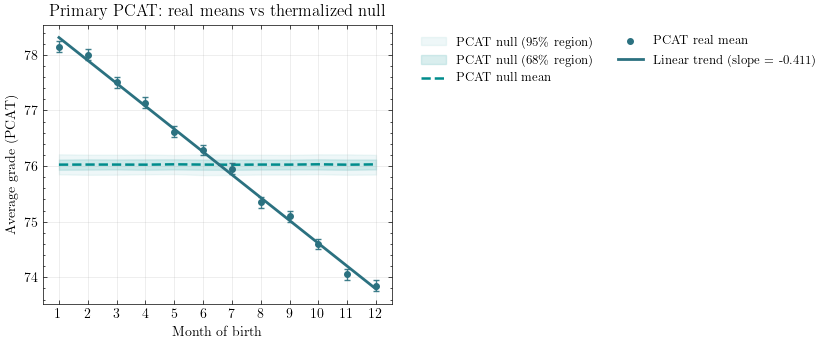

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/2489150499.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


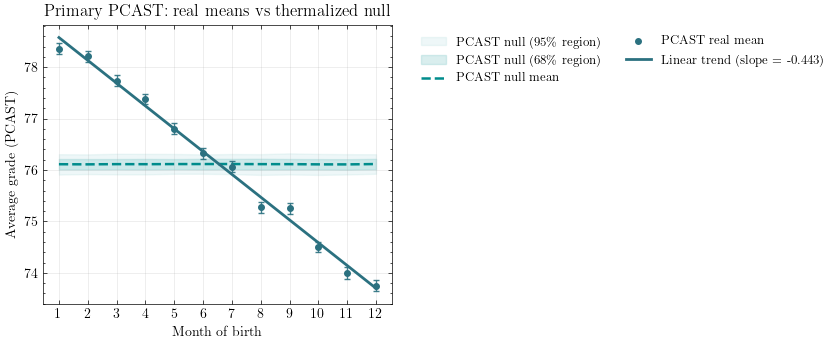

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/2489150499.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


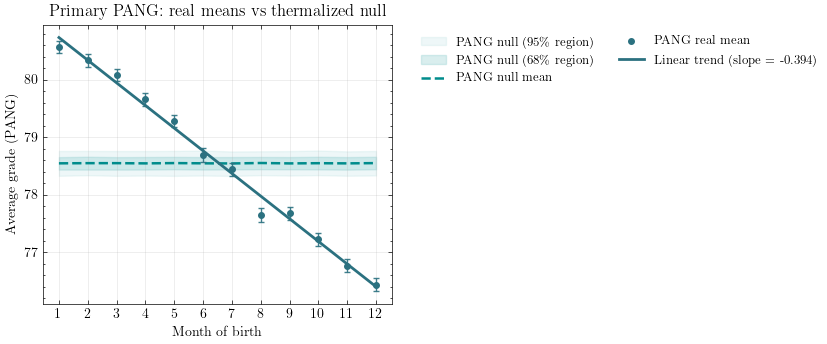

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/2489150499.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


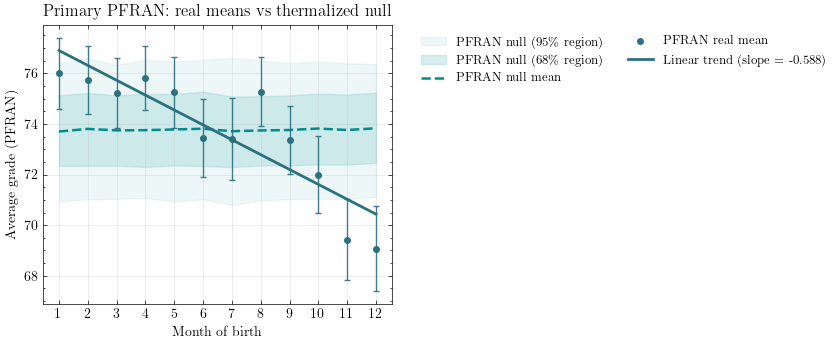

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/2489150499.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


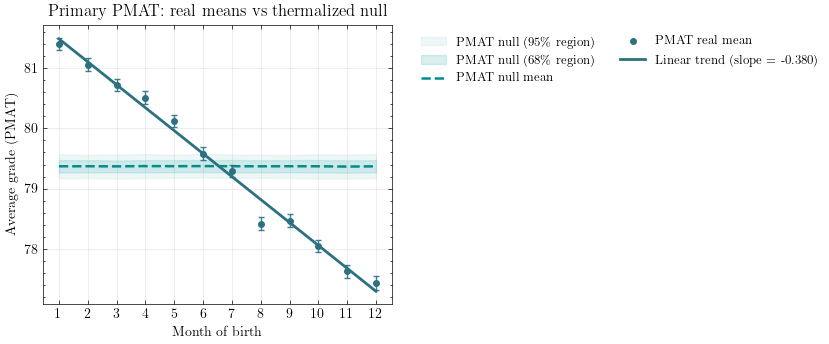

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/2489150499.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


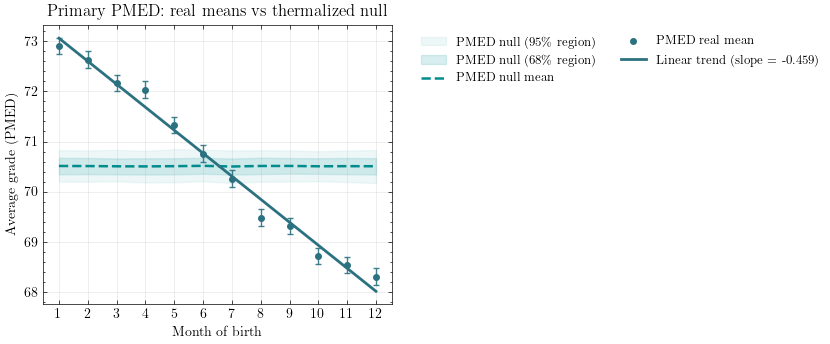

In [26]:
plt.style.use("birthmonth.mplstyle")

# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# 3. Plot and save all subjects (Primary)
# --------------------------------------------------------
os.makedirs(birth_dir_nogender_primary, exist_ok=True)

for subj in subjects_P:
    summary_P = primary_summaries[subj]

    months     = summary_P['month'].values
    real_mean  = summary_P['real_mean'].values
    real_std   = summary_P['real_std'].values     # <-- spread of grades, what you want
    band_min   = summary_P['band_min'].values
    band_max   = summary_P['band_max'].values
    band_mean  = summary_P['null_mean'].values
    band_p16   = summary_P['band_p16'].values     # ≈ 16th percentile (inner band)
    band_p84   = summary_P['band_p84'].values     # ≈ 84th percentile
    band_p2_5  = summary_P['band_p2_5'].values    # ≈ 2.5th percentile (outer band)
    band_p97_5 = summary_P['band_p97_5'].values   # ≈ 97.5th percentile

    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    # Colors from your palette dict
    band_color  = palette['primary']['thermalized_band']
    mean_color  = palette['primary']['thermalized_mean_line']
    point_color = palette['primary']['points']

    # ----- Outer thermalized band (~95% central region of null) -----
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15,
        label=f'{subj} null (95\% region)'
    )

    # ----- Inner thermalized band (~68% central region of null) -----
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35,
        label=f'{subj} null (68\% region)'
    )

    # Optional absolute envelope
    # ax.fill_between(months, band_min, band_max, color=band_color, alpha=0.05)

    # Thermalized mean line (null mean)
    ax.plot(
        months, band_mean,
        linestyle='--', linewidth=1.8,
        color=mean_color,
        marker=None,
        label=f'{subj} null mean'
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label=f'{subj} real mean'
    )

    real_sem = real_std / np.sqrt(summary_P['real_n'].values)
    # Error bars for real means: ± standard deviation of grades
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,          # choose
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=f'Linear trend (slope = {slope:.3f})'
        )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real means vs thermalized null')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()

    for ax in (fig.axes):
        ax.tick_params(axis='x', which='minor', length=0)

    filename = f"primary_{subj}_thermalization.png"
    fig.savefig(os.path.join(birth_dir_nogender_primary, filename), dpi=900, bbox_inches='tight')

    plt.show()
    plt.close(fig)


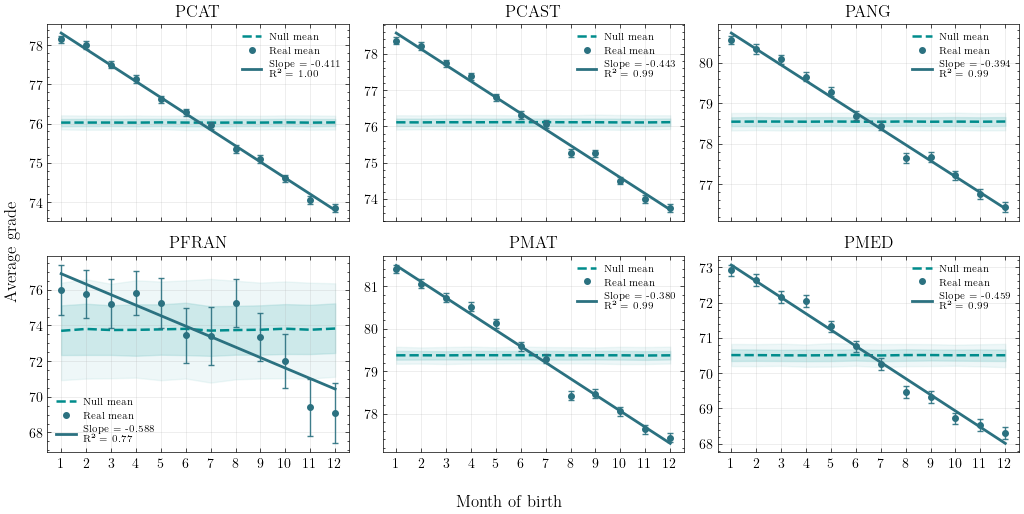

In [53]:
plt.style.use("birthmonth.mplstyle")

#--------------------------
#       MULTIPLOT
#--------------------------

# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# Multiplot for all Primary subjects (no legends)
# --------------------------------------------------------
os.makedirs(birth_dir_nogender_primary, exist_ok=True)

n_subj = len(subjects_P)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True,   # same month axis
    sharey=False   # let each subject choose its own y-range (like secondary)
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_P):
    summary_P = primary_summaries[subj]

    months     = summary_P['month'].values
    real_mean  = summary_P['real_mean'].values
    real_std   = summary_P['real_std'].values
    real_n     = summary_P['real_n'].values
    band_mean  = summary_P['null_mean'].values
    band_p16   = summary_P['band_p16'].values
    band_p84   = summary_P['band_p84'].values
    band_p2_5  = summary_P['band_p2_5'].values
    band_p97_5 = summary_P['band_p97_5'].values

    # Colors from your palette dict
    band_color  = palette['primary']['thermalized_band']
    mean_color  = palette['primary']['thermalized_mean_line']
    point_color = palette['primary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15
    )

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35
    )

    # Thermalized mean line (null mean)
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None,
        label='Null mean'
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label='Real mean'
    )

    # SEM from SD and n
    real_sem = np.where(real_n > 0, real_std / np.sqrt(real_n), np.nan)

    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    # Linear regression on real means, with slope and R^2 in legend
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months
        r2 = r**2

        trend_label = f'Slope = {slope:.3f}\nR² = {r2:.2f}'

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=trend_label
        )

        ax.legend(fontsize=7, loc='best')

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Hide unused axes if any
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

# Remove minor x ticks
for ax in fig.axes:
    ax.tick_params(axis='x', which='minor', length=0)

fig.tight_layout()
fig.savefig(
    os.path.join(birth_dir_nogender_primary, "all_primary_subjects_multiplot.png"),
    dpi=900,
    bbox_inches='tight'
)
plt.show()



#### Secondary plots

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/1042713509.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


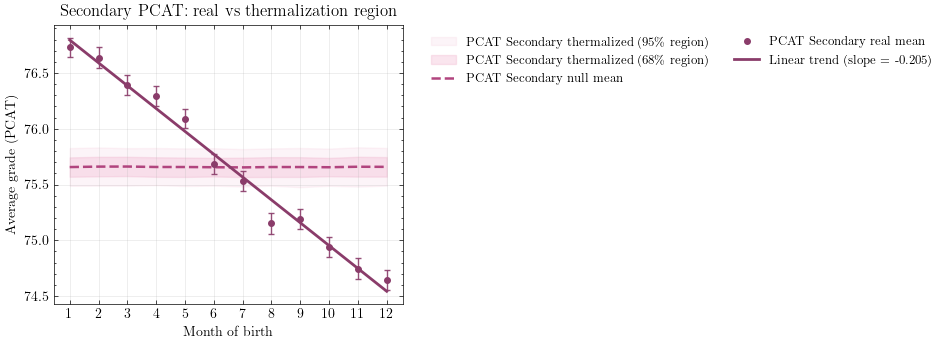

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/1042713509.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


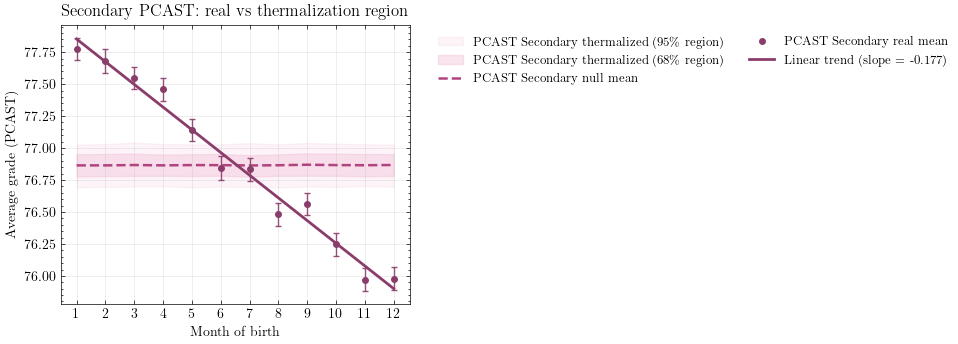

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/1042713509.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


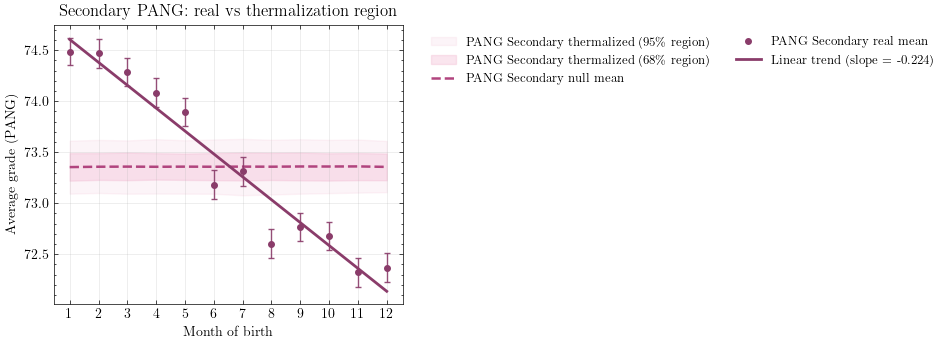

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/1042713509.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


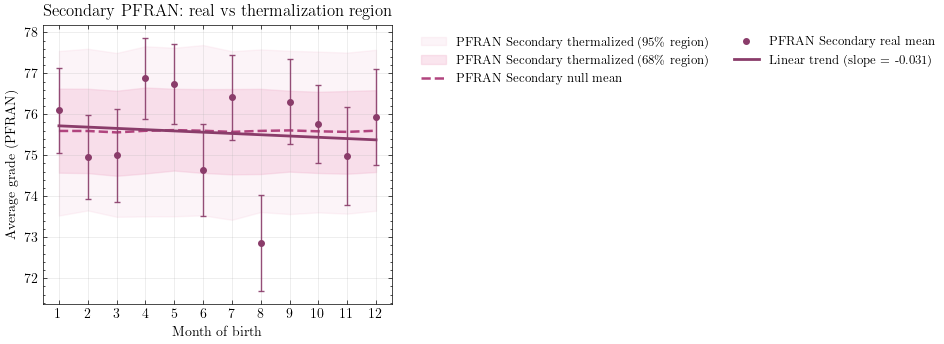

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/1042713509.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


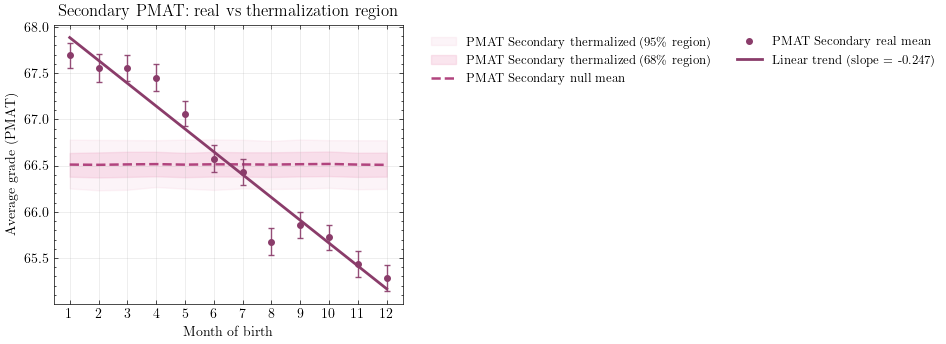

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/1042713509.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


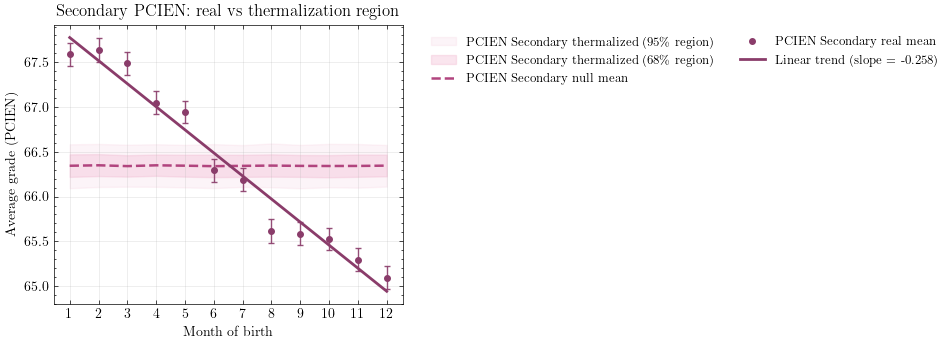

In [27]:
plt.style.use("birthmonth.mplstyle")

# --------------------------------------------------------
# 3. Plot for all subjects (Secondary)
# --------------------------------------------------------
os.makedirs(birth_dir_nogender_secondary, exist_ok=True)

for subj in subjects_S:
    summary_S = secondary_summaries[subj]

    months     = summary_S['month'].values
    real_mean  = summary_S['real_mean'].values
    real_std   = summary_S['real_std'].values    # spread of grades
    band_mean  = summary_S['null_mean'].values
    band_p16   = summary_S['band_p16'].values
    band_p84   = summary_S['band_p84'].values
    band_p2_5  = summary_S['band_p2_5'].values
    band_p97_5 = summary_S['band_p97_5'].values

    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    # Colors from your palette dict
    band_color  = palette['secondary']['thermalized_band']
    mean_color  = palette['secondary']['thermalized_mean_line']
    point_color = palette['secondary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15,
        label=f'{subj} Secondary thermalized (95\% region)'
    )

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35,
        label=f'{subj} Secondary thermalized (68\% region)'
    )

    # Thermalized mean line
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None,
        label=f'{subj} Secondary null mean'
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label=f'{subj} Secondary real mean'
    )

    real_sem = real_std / np.sqrt(summary_S['real_n'].values)
    # Error bars on real means: ± standard deviation of grades
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    # Linear regression on real means
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=f'Linear trend (slope = {slope:.3f})'
        )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Secondary {subj}: real vs thermalization region')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    for ax in (fig.axes):
        ax.tick_params(axis='x', which='minor', length=0)

    filename = f"secondary_{subj}_thermalization.png"
    fig.savefig(os.path.join(birth_dir_nogender_secondary, filename), dpi=900, bbox_inches='tight')

    plt.show()
    plt.close(fig)


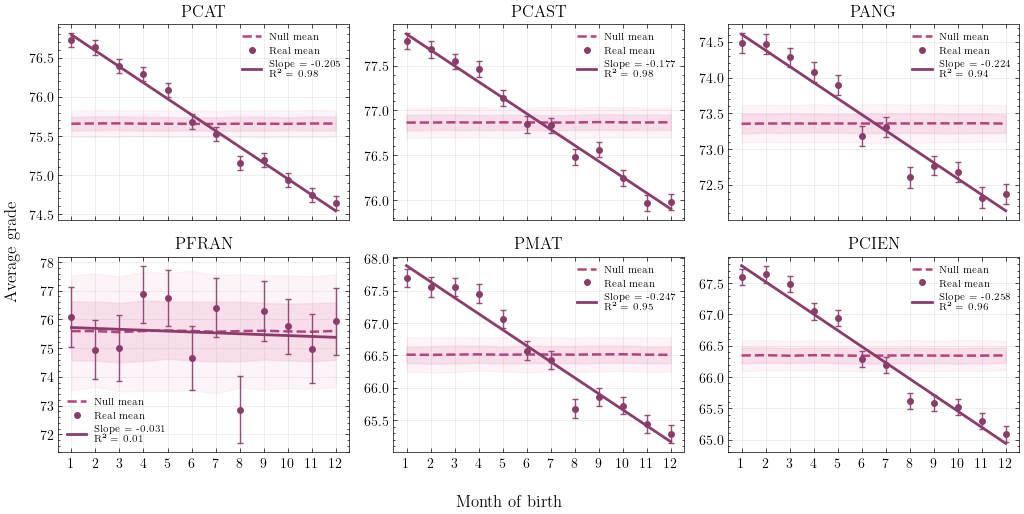

In [52]:
plt.style.use("birthmonth.mplstyle")

#--------------------------
#       MULTIPLOT
#--------------------------

# --------------------------------------------------------
# SECONDARY MAIN SUBJECTS
# --------------------------------------------------------
n_iter = 2000

# --------------------------------------------------------
# Multiplot for all Secondary subjects (no legends)
# --------------------------------------------------------
os.makedirs(birth_dir_nogender_secondary, exist_ok=True)

n_subj = len(subjects_S)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True,   # same month axis
    sharey=False   # each subject chooses its own y-range
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_S):
    summary_S = secondary_summaries[subj]

    months     = summary_S['month'].values
    real_mean  = summary_S['real_mean'].values
    real_std   = summary_S['real_std'].values
    real_n     = summary_S['real_n'].values
    band_mean  = summary_S['null_mean'].values
    band_p16   = summary_S['band_p16'].values
    band_p84   = summary_S['band_p84'].values
    band_p2_5  = summary_S['band_p2_5'].values
    band_p97_5 = summary_S['band_p97_5'].values

    # Colors from your palette dict (secondary)
    band_color  = palette['secondary']['thermalized_band']
    mean_color  = palette['secondary']['thermalized_mean_line']
    point_color = palette['secondary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15
    )

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35
    )

    # Thermalized mean line (null mean)
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None,
        label='Null mean'
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label='Real mean'
    )

    # SEM from SD and n
    real_sem = np.where(real_n > 0, real_std / np.sqrt(real_n), np.nan)

    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    # ----- Linear regression on real means, with slope and R^2 in legend -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months
        r2 = r**2  # coefficient of determination [web:189][web:195]

        trend_label = f'Slope = {slope:.3f} \n R² = {r2:.2f}'

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=trend_label
        )

        ax.legend(fontsize=7, loc='best')

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Hide unused axes if any
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Remove minor x ticks in all panels
for ax in fig.axes:
    ax.tick_params(axis='x', which='minor', length=0)

# Common labels on outer figure
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

fig.tight_layout()
fig.savefig(
    os.path.join(birth_dir_nogender_secondary, "all_secondary_subjects_multiplot.png"),
    dpi=900,
    bbox_inches='tight'
)
plt.show()


## 3. Primary and Secondary comparison

### Z score

In [40]:
plt.style.use("birthmonth.mplstyle")

cmap_icefire = sns.color_palette("coolwarm", as_cmap=True)

os.makedirs(birth_dir_nogender, exist_ok=True)

def plot_summary_heatmaps(df_stats, level_label, filename_prefix):
    """
    df_stats: df_stats_primary_all or df_stats_secondary_all
              must contain columns:
              subject, month, z_score, real_mean, null_mean

    Heatmap colors = Z-score (distance from null in sigmas).
    Cell annotations = Δgrade (real_mean - null_mean), in grade points.
    """
    # Ensure month is numeric and sorted
    df = df_stats.copy()
    df['month'] = pd.to_numeric(df['month'], errors='coerce')
    df = df.dropna(subset=['month'])

    # Sorted unique months
    months_sorted = sorted(df['month'].unique())

    # Desired subject order, depending on level_label
    subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
    subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']

    if level_label.lower().startswith("prim"):
        subject_order = subjects_P
    elif level_label.lower().startswith("sec"):
        subject_order = subjects_S
    else:
        # fallback: whatever subjects appear, in their current order
        subject_order = df['subject'].unique().tolist()

    # Pivot for colors: Z-scores
    z_pivot = (
        df.pivot_table(index='subject', columns='month', values='z_score')
          .reindex(index=subject_order)       # enforce subject order
          .reindex(columns=months_sorted)     # enforce month order
    )

    # --- Z-score heatmap ---
    fig, ax = plt.subplots(figsize=(6, 3.5))

    sns.heatmap(
        z_pivot,
        ax=ax,
        cmap=cmap_icefire,      # color encodes how many sigmas from null
        center=0,
        annot=True,      # numbers shown = z score
        fmt='.2f',              # show with 2 decimals
        vmin=-25,
        vmax=25,
        cbar_kws={'label': 'Z-score'},
        annot_kws={'fontsize': 8}
    )

    # Get rid of tick lines in the heatmap axes
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_title(f'{level_label} – Effect of birth month on grades\n'
    '(Z-score analysis)'
    )

    ax.set_ylabel('Subject')
    ax.set_xlabel('Month of birth')

    # Force x tick labels to be 1, 2, 3, ...
    month_labels = [str(int(m)) for m in months_sorted]
    ax.set_xticks(np.arange(len(months_sorted)) + 0.5)  # center ticks on cells
    ax.set_xticklabels(month_labels, rotation=0)

    fig.tight_layout()

    filename = f"3.{filename_prefix}_zscore_heatmap.png"
    fig.savefig(os.path.join(birth_dir_nogender, filename), dpi=900, bbox_inches='tight')
    plt.show()



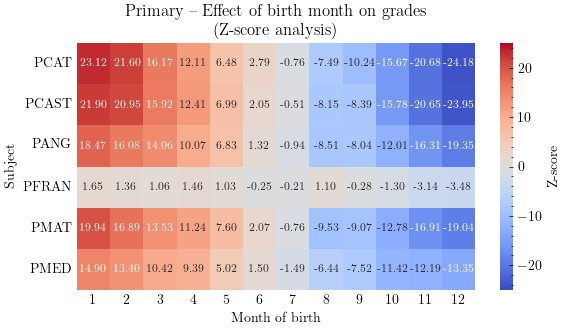

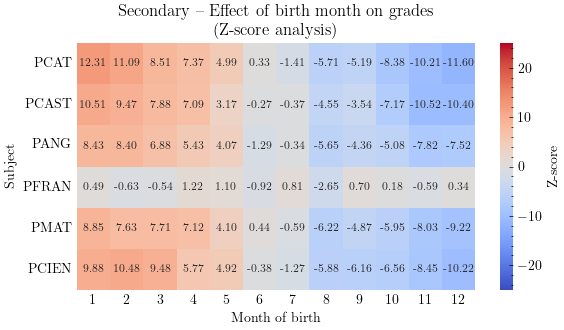

In [42]:
# Calls
plot_summary_heatmaps(df_stats_primary_all,  'Primary',   'primary')
plot_summary_heatmaps(df_stats_secondary_all, 'Secondary', 'secondary')

### In which subjects and months does Secondary improve more or less than Primary relative to noise?

**We can see that on the area between the real points and the noise region. Does it increase or decrease?**

Now, we compute $area_{level, subject} = \sum_{m=1}^{12} | real\_ mean(m) - null\_ mean(m)| $

In [35]:
plt.style.use("birthmonth.mplstyle")

os.makedirs(birth_dir_nogender, exist_ok=True)

# Common subject order, mapping PCIEN -> PMED in Secondary
subject_order = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']

# --- Prepare Primary ---
dfP = df_stats_primary_all.copy()
dfP['month'] = pd.to_numeric(dfP['month'], errors='coerce')
dfP = dfP.dropna(subset=['month'])

# Improvement vs null
dfP['delta_grade'] = dfP['real_mean'] - dfP['null_mean']

# Absolute area per subject (sum over months)
area_P = (
    dfP.groupby('subject')['delta_grade']
       .apply(lambda s: np.nansum(np.abs(s.values)))
       .reindex(subject_order)
)

# Signed area (optional, if you want net direction)
net_P = (
    dfP.groupby('subject')['delta_grade']
       .apply(lambda s: np.nansum(s.values))
       .reindex(subject_order)
)

# --- Prepare Secondary ---
dfS = df_stats_secondary_all.copy()
dfS['month'] = pd.to_numeric(dfS['month'], errors='coerce')
dfS = dfS.dropna(subset=['month'])

# Map PCIEN to PMED
subject_map_S_to_P = {'PCIEN': 'PMED'}
dfS['subject'] = dfS['subject'].replace(subject_map_S_to_P)

dfS['delta_grade'] = dfS['real_mean'] - dfS['null_mean']

area_S = (
    dfS.groupby('subject')['delta_grade']
       .apply(lambda s: np.nansum(np.abs(s.values)))
       .reindex(subject_order)
)

net_S = (
    dfS.groupby('subject')['delta_grade']
       .apply(lambda s: np.nansum(s.values))
       .reindex(subject_order)
)

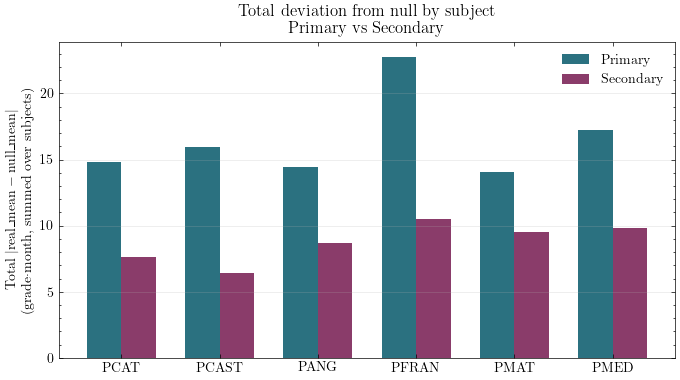

In [36]:
x = np.arange(len(subject_order))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4))

# Bars for absolute areas per level
# use the color palette for points
ax.bar(x - width/2, area_P.values, width, label='Primary', color=palette['primary']['points'])
ax.bar(x + width/2, area_S.values, width, label='Secondary', color=palette['secondary']['points'])

ax.set_xticks(x)
ax.set_xticklabels(subject_order)
ax.set_ylabel(
    r'Total $\left| \mathrm{real\_mean} - \mathrm{null\_mean} \right|$'
    '\n(grade·month, summed over subjects)'
)
ax.set_title('Total deviation from null by subject\nPrimary vs Secondary')
ax.legend()
ax.grid(axis='y', alpha=0.3)

fig.tight_layout()
for ax in (fig.axes):
    ax.tick_params(axis='x', which='minor', length=0)
fig.savefig(os.path.join(birth_dir_nogender, "4.area_primary_vs_secondary_by_subject.png"),
            dpi=900, bbox_inches='tight')
plt.show()

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_54194/4181248181.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


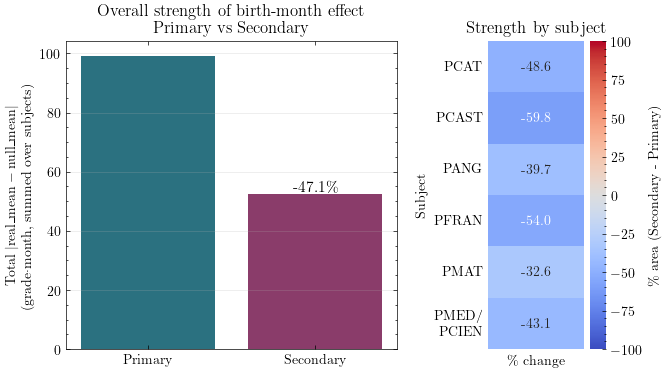

In [46]:
mpl.rcParams['text.usetex'] = True

plt.style.use("birthmonth.mplstyle")

# ----------------------------------------
# Total area across all subjects
# ----------------------------------------
total_area_P = np.nansum(area_P.values)
total_area_S = np.nansum(area_S.values)

# % change Secondary vs Primary (global)
diff_pct = 100 * (total_area_S - total_area_P) / total_area_P

from matplotlib import gridspec

fig = plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(
    1, 2, width_ratios=[2.2, 0.8], wspace=0.4
)

ax_bar = fig.add_subplot(gs[0, 0])
ax_col = fig.add_subplot(gs[0, 1])

# ------- LEFT: bar plot Primary vs Secondary -------
levels = ['Primary', 'Secondary']
totals = [total_area_P, total_area_S]

bars = ax_bar.bar(
    levels, totals,
    color=[palette['primary']['points'],
           palette['secondary']['points']]
)

ax_bar.set_ylabel(
    r'Total $\left| \mathrm{real\_mean} - \mathrm{null\_mean} \right|$'
    '\n(grade·month, summed over subjects)'
)
ax_bar.set_title('Overall strength of birth-month effect \n Primary vs Secondary')
ax_bar.grid(axis='y', alpha=0.3)

# Annotate +/- % on top of the Secondary bar
bar_sec = bars[1]
x_sec = bar_sec.get_x() + bar_sec.get_width() / 2
y_sec = bar_sec.get_height()

ax_bar.text(
    x_sec, y_sec,
    f'{diff_pct:+.1f}\%',
    ha='center', va='bottom',
    fontsize=11
)

ax_bar.tick_params(axis='x', which='minor', length=0)

# ------- RIGHT: per-subject % area change column -------
area_diff = area_S - area_P
area_pct  = 100 * area_diff / area_P   # % change per subject

df_pct = area_pct.to_frame(name='\% change')

# Rename PMED to PMED/PCIEN for the label
df_pct = df_pct.rename(index={'PMED': 'PMED/\nPCIEN'})

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(
    df_pct,
    ax=ax_col,
    cmap=cmap,
    center=0,
    vmin=-100,
    vmax=100,
    annot=True,
    fmt='+.1f',
    cbar_kws={'label': '\% area (Secondary - Primary)'}
)

ax_col.set_xlabel('')
ax_col.set_ylabel('Subject')
ax_col.tick_params(axis='both', which='both', length=0)
ax_col.set_title('Strength by subject')

# Make subject labels horizontal
ax_col.set_yticklabels(ax_col.get_yticklabels(), rotation=0)

fig.tight_layout()

fig.savefig(
    os.path.join(birth_dir_nogender, "4.area_total_primary_vs_secondary_with_subject.png"),
    dpi=900,
    bbox_inches='tight'
)
plt.show()

# End of the notebook. See `BirthMonth-Gender.ipynb` for more